In [1]:
import os.path, sys

import numpy as np
import pandas as pd
from scipy import linalg
from scipy.sparse import csr_matrix
from sklearn.preprocessing import OneHotEncoder

import Bio.PDB, warnings
pdb_list = Bio.PDB.PDBList()
pdb_parser = Bio.PDB.PDBParser()
from scipy.spatial import distance_matrix
from Bio import BiopythonWarning
warnings.simplefilter('ignore', BiopythonWarning)

from joblib import Parallel, delayed
import timeit

import matplotlib.pyplot as plt

# # --- Import our Code ---# #
#import emachine as EM
from direct_info import direct_info

# import data processing and general DCA_ER tools
from data_processing import data_processing_pdb2msa, pdb2msa
import ecc_tools as tools
from pathlib import Path

np.random.seed(1)

In [40]:
create_new = True
printing = True
removing_cols = True
remove_diagonals = False


data_path = Path('/data/cresswellclayec/DCA_ER/Pfam-A.full')


# Define data directories
DCA_ER_dir = '/data/cresswellclayec/DCA_ER' # Set DCA_ER directory
biowulf_dir = '%s/biowulf_pdb2msa' % DCA_ER_dir


out_dir = '%s/protein_data/di/' % biowulf_dir
out_metric_dir = '%s/protein_data/metrics/' % biowulf_dir

processed_data_dir = "%s/protein_data/data_processing_output" % biowulf_dir
pdb_dir = '%s/protein_data/pdb_data/' % biowulf_dir

pdb_path = "/pdb/pdb/zd/pdb1zdr.ent.gz"
# pdb_path = sys.argv[1]
n_cpus = 6
print('\n\nUnzipping %s' % pdb_path)

unzipped_pdb_filename = os.path.basename(pdb_path).replace(".gz", "")

pdb_out_path = "%s%s" % (pdb_dir, unzipped_pdb_filename)
print('Unzipping %s to %s' % (pdb_path, pdb_out_path))





Unzipping /pdb/pdb/zd/pdb1zdr.ent.gz
Unzipping /pdb/pdb/zd/pdb1zdr.ent.gz to /data/cresswellclayec/DCA_ER/biowulf_pdb2msa/protein_data/pdb_data/pdb1zdr.ent


## Using PDB-->MSA with Prody

In [3]:
import gzip, shutil
def gunzip(file_path,output_path):
    with gzip.open(file_path,"rb") as f_in, open(output_path,"wb") as f_out:
        shutil.copyfileobj(f_in, f_out)

        
unzipped_pdb_filename = os.path.basename(pdb_path).replace(".gz", "")

pdb_out_path = "%s%s" % (pdb_dir, unzipped_pdb_filename)
print('Unzipping %s to %s' % (pdb_path, pdb_out_path))

gunzip(pdb_path, pdb_out_path)
print(pdb_out_path)
print(pdb_dir)

Unzipping /pdb/pdb/zd/pdb1zdr.ent.gz to /data/cresswellclayec/DCA_ER/biowulf_pdb2msa/protein_data/pdb_data/pdb1zdr.ent
/data/cresswellclayec/DCA_ER/biowulf_pdb2msa/protein_data/pdb_data/pdb1zdr.ent
/data/cresswellclayec/DCA_ER/biowulf_pdb2msa/protein_data/pdb_data/


In [4]:
print(pdb_out_path)
print(pdb_dir)
pdb2msa_results = pdb2msa(pdb_out_path, pdb_dir, create_new=True)
print(pdb2msa_results)

if len(pdb2msa_results) > 1:
    fasta_file = pdb2msa_results[0]
    prody_df = pdb2msa_results[1]
else:
    prody_df = pdb2msa_results[0]


                                                                                                                                                                                                                                         

/data/cresswellclayec/DCA_ER/biowulf_pdb2msa/protein_data/pdb_data/pdb1zdr.ent
/data/cresswellclayec/DCA_ER/biowulf_pdb2msa/protein_data/pdb_data/
1zdr
Record id 1ZDR:A, chain A
['PDB:1ZDR', 'PDB:1ZDR']
Record id 1ZDR:B, chain B
['PDB:1ZDR', 'PDB:1ZDR']

Chain A polypeptide 0 (length 161):  MISHIVAMDENRVIGKDNRLPWHLPADLAYFKRVTMGHAIVMGRKTFEAIGRPLPGRDNVVVTGNRSFRPEGCLVLHSLEEVKQWIASRADEVFIIGGAELFRATMPIVDRLYVTKIFASFPGDTFYPPISDDEWEIVSYTPGGKDEKNPYEHAFIIYERK


@> Submitted Pfam search for sequence "MISHIVAMDENRVIGK...".


{'PF00186': {'accession': 'PF00186.22', 'class': 'Domain', 'id': 'DHFR_1', 'locations': {'ali_end': '160', 'ali_start': '1', 'bitscore': '215.08', 'end': '160', 'cond_evalue': '2.3e-68', 'ind_evalue': '4.6e-64', 'evidence': 'hmmer v3.0', 'hmm_end': '160', 'hmm_start': '1', 'start': '1'}, 'type': 'Pfam-A'}}

Chain B polypeptide 0 (length 160):  MISHIVAMDENRVIGKDNRLPWHLPADLAYFKRVTMGHAIVMGRKTFEAIGRPLPGRDNVVVTGNRSFRPEGCLVLHSLEEVKQWIASRADEVFIIGGAELFRATMPIVDRLYVTKIFASFPGDTFYPPISDDEWEIVSYTPGGKDEKNPYEHAFIIYER


@> Submitted Pfam search for sequence "MISHIVAMDENRVIGK...".


{'PF00186': {'accession': 'PF00186.22', 'class': 'Domain', 'id': 'DHFR_1', 'locations': {'ali_end': '160', 'ali_start': '1', 'bitscore': '215.11', 'end': '160', 'cond_evalue': '2.3e-68', 'ind_evalue': '4.5e-64', 'evidence': 'hmmer v3.0', 'hmm_end': '160', 'hmm_start': '1', 'start': '1'}, 'type': 'Pfam-A'}}
  PDB ID Chain  Polypeptide Index     Pfam   accession   class      id  \
0   1zdr     A                  0  PF00186  PF00186.22  Domain  DHFR_1   
1   1zdr     B                  0  PF00186  PF00186.22  Domain  DHFR_1   

     type                                       PDB Sequence  ali_end  \
0  Pfam-A  MISHIVAMDENRVIGKDNRLPWHLPADLAYFKRVTMGHAIVMGRKT...      160   
1  Pfam-A  MISHIVAMDENRVIGKDNRLPWHLPADLAYFKRVTMGHAIVMGRKT...      160   

   ali_start  bitscore  end   cond_evalue    ind_evalue    evidence  hmm_end  \
0          1    215.08  160  2.300000e-68  4.600000e-64  hmmer v3.0      160   
1          1    215.11  160  2.300000e-68  4.500000e-64  hmmer v3.0      160   

   hmm_s

In [5]:
print('\nPDB DF with associated Protein Families\n', prody_df.loc[:,  [column for column in prody_df.columns if column not in ['locations', 'PDB Sequence']]].head())


for ir, pdb2msa_row in enumerate(prody_df.iterrows()):
    print('\n\nGetting msa with following pdb2msa entry:\n', pdb2msa_row)
    try:
        dp_result =  data_processing_pdb2msa(data_path, prody_df.iloc[pdb2msa_row[0]], gap_seqs=0.2, gap_cols=0.2, prob_low=0.004,
                               conserved_cols=0.8, printing=True, out_dir=processed_data_dir, pdb_dir=pdb_dir, letter_format=False,
                               remove_cols=True, create_new=True, n_cpu=min(2, n_cpus))
        if dp_result is not None:
            [s0, removed_cols, s_index, tpdb] = dp_result
            break
        else:
            continue
    except Exception as e:
        print('row %d got exception: ' % ir , e)
        print('moving on.. ')
        pass
pfam_id = pdb2msa_row[1]['Pfam']
pdb_id = pdb2msa_row[1]['PDB ID']

print('Done...')
                    


PDB DF with associated Protein Families
   PDB ID Chain  Polypeptide Index     Pfam   accession   class      id  \
0   1zdr     B                  0  PF00186  PF00186.22  Domain  DHFR_1   
1   1zdr     A                  0  PF00186  PF00186.22  Domain  DHFR_1   

     type  ali_end  ali_start  bitscore  end   cond_evalue    ind_evalue  \
0  Pfam-A      160          1    215.11  160  2.300000e-68  4.500000e-64   
1  Pfam-A      160          1    215.08  160  2.300000e-68  4.600000e-64   

     evidence  hmm_end  hmm_start  start  
0  hmmer v3.0      160          1      1  
1  hmmer v3.0      160          1      1  


Getting msa with following pdb2msa entry:
 (0, PDB ID                                                            1zdr
Chain                                                                B
Polypeptide Index                                                    0
Pfam                                                           PF00186
accession                                   

In [6]:
# number of positions
n_var = s0.shape[1]
n_seq = s0.shape[0]

print("Number of residue positions:",n_var)
print("Number of sequences:",n_seq)

# number of aminoacids at each position
mx = np.array([len(np.unique(s0[:,i])) for i in range(n_var)])
#mx = np.array([m for i in range(n_var)])
print("Number of different amino acids at each position",mx)

mx_cumsum = np.insert(mx.cumsum(),0,0)
i1i2 = np.stack([mx_cumsum[:-1],mx_cumsum[1:]]).T 
# print("(Sanity Check) Column indices of first and (",i1i2[0],") and last (",i1i2[-1],") positions")
# print("(Sanity Check) Column indices of second and (",i1i2[1],") and second to last (",i1i2[-2],") positions")


# number of variables
mx_sum = mx.sum()
print("Total number of variables",mx_sum)

# number of bias term
n_linear = mx_sum - n_var

Number of residue positions: 133
Number of sequences: 6573
Number of different amino acids at each position [ 6 16 12  7  8 16  8 17 12 14  9 19 11 10 13  5  5 14  9  5 11  9 12 10
  9 10 16 17 11 12 13  5  4  9  7 11  5 10 12  9  9 17  8  8  5  2 11 11
 18 18 20 20 20 14 13 15 16 15 14 14  7 12 15 12  8 15 15 21 19 16 16 20
 15 17 13 11  8 10 11 13  4  3 13 15 12 11 13 19  9 11 17  7 14  8 16  3
 16 19 15 14 15  7  7 15  7 17 10 16 20 17 18  5 17 16 17 19 19 18 21 21
 19 15 17 13 16 13 14 10 14  9 18 14  5]
Total number of variables 1678


In [7]:
onehot_encoder = OneHotEncoder(sparse=False,categories='auto')
# s is OneHot encoder format, s0 is original sequnce matrix
s = onehot_encoder.fit_transform(s0)
# print("Amino Acid sequence Matrix\n",s0)
# print("OneHot sequence Matrix\n",s)
# print("An individual element of the OneHot sequence Matrix (size:",
#      s.shape,") --> ",s[0], " has length ",s[0].shape)

In [8]:
# Define wight matrix with variable for each possible amino acid at each sequence position
w = np.zeros((mx.sum(),mx.sum())) 
h0 = np.zeros(mx.sum())

In [9]:
import sys
import numpy as np
from scipy import linalg
from sklearn.preprocessing import OneHotEncoder
import expectation_reflection as ER
from direct_info import direct_info
from joblib import Parallel, delayed

In [11]:
# Expectation Reflection
#=========================================================================================
def predict_w(s,i0,i1i2,niter_max,l2):
    #print('i0:',i0)
    i1,i2 = i1i2[i0,0],i1i2[i0,1]

    x = np.hstack([s[:,:i1],s[:,i2:]])
    y = s[:,i1:i2]

    h01,w1 = ER.fit(x,y,niter_max,l2)

    return h01,w1

create_new=False
w_file = "%s/%s_%s_w.npy" % (processed_data_dir, pdb_id, pfam_id)
if os.path.exists(w_file) and not create_new:
    w = np.load(w_file)
else:
    #-------------------------------
    # parallel
    start_time = timeit.default_timer()
    #res = Parallel(n_jobs = 4)(delayed(predict_w)\
    #res = Parallel(n_jobs = 8)(delayed(predict_w)\
    res = Parallel(n_jobs = 32)(delayed(predict_w)\
            (s,i0,i1i2,niter_max=10,l2=100.0)\
            for i0 in range(n_var))

    run_time = timeit.default_timer() - start_time
    print('run time:',run_time)
    ## This above line seems wrong, seems like the following for loop should be moved up?? not sure if this is some 
    ## python implementation or just wrong
    #-------------------------------
    for i0 in range(n_var):
        i1,i2 = i1i2[i0,0],i1i2[i0,1]

        h01 = res[i0][0]
        w1 = res[i0][1]

        h0[i1:i2] = h01
        w[:i1,i1:i2] = w1[:i1,:]
        w[i2:,i1:i2] = w1[i1:,:]

    # make w symmetric
    w = (w + w.T)/2.


In [12]:
if not create_new and os.path.exists("%s/%s_%s_ER_di.npy" % (out_dir, pdb_id, pfam_id)):
    di = np.load("%s/%s_%s_ER_di.npy" % (out_dir, pdb_id, pfam_id))
else:
    di = direct_info(s0,w)
    np.save("%s/%s_%s_ER_di.npy" % (out_dir, pdb_id, pfam_id), di)
print(di)
print(di.shape)


[[0.         0.11992473 0.01892473 ... 0.00573002 0.00521845 0.00641328]
 [0.11992473 0.         0.02627038 ... 0.0049008  0.01032049 0.00892166]
 [0.01892473 0.02627038 0.         ... 0.0054467  0.005744   0.00819328]
 ...
 [0.00573002 0.0049008  0.0054467  ... 0.         0.03667702 0.106871  ]
 [0.00521845 0.01032049 0.005744   ... 0.03667702 0.         0.09783351]
 [0.00641328 0.00892166 0.00819328 ... 0.106871   0.09783351 0.        ]]
(133, 133)


In [15]:
print(pdb2msa_row)

(0, PDB ID                                                            1zdr
Chain                                                                B
Polypeptide Index                                                    0
Pfam                                                           PF00186
accession                                                   PF00186.22
class                                                           Domain
id                                                              DHFR_1
type                                                            Pfam-A
PDB Sequence         MISHIVAMDENRVIGKDNRLPWHLPADLAYFKRVTMGHAIVMGRKT...
ali_end                                                            160
ali_start                                                            1
bitscore                                                        215.11
end                                                                160
cond_evalue                                                        0.0
in

In [34]:
from numba import prange as parallel_range
import numpy as np
import sys, os, errno
import pandas as pd
# Import Bio data processing features 
from Bio import SeqIO
import Bio.PDB, warnings
from Bio.PDB import *
from scipy.spatial import distance_matrix
from Bio import BiopythonWarning
from Bio import pairwise2
from Bio.SubsMat.MatrixInfo import blosum62
from matplotlib import colors as mpl_colors
import random
import xml.etree.ElementTree as et
from pathlib import Path
from data_processing import data_processing, find_and_replace, data_processing_msa2pdb, load_msa
from sklearn.metrics import roc_curve as roc_scikit
from sklearn.metrics import auc, precision_recall_curve

warnings.filterwarnings("error")
warnings.simplefilter('ignore', BiopythonWarning)
warnings.simplefilter('ignore', DeprecationWarning)
warnings.simplefilter('ignore', FutureWarning)
warnings.filterwarnings("ignore", message="numpy.dtype size changed")
warnings.filterwarnings("ignore", message="numpy.ufunc size changed")
pdb_list = Bio.PDB.PDBList()
pdb_parser = Bio.PDB.PDBParser()

from ecc_tools import filter_residues, no_diag

def contact_map_pdb2msa(pdb_df, pdb_file, removed_cols, pdb_out_dir='./', printing=True):
    if printing:
        print('\n\n#-----------------------#\nGenerating Contact Map\n#----------------------------#\n')

    pdb_id = pdb_df['PDB ID']
    # pdb_file = pdb_list.retrieve_pdb_file(pdb_id)

    pdb_start = pdb_df['ali_start'] - 1
    pdb_end = pdb_df['ali_end'] 
    pdb_chain = pdb_df['Chain']
    pdb_pp_index = pdb_df['Polypeptide Index']

    pdb_model = pdb_parser.get_structure(str(pdb_id), pdb_file)[0]
    found_pp_match = False
    for chain in pdb_model.get_chains():
        if chain.get_id() == pdb_chain:
            pass
        else:
            continue
        ppb = PPBuilder().build_peptides(chain)

        # # PYDCA method for getting polypeptide sequence...
        poly_seq_new = [res.get_resname().strip() for res in filter_residues(pdb_model[chain.get_id()].get_list())]
        print('new poly seq list: ', ''.join(poly_seq_new))

        # Get full list of CA coords from poly_seq
        poly_seq = list()
        pp_ca_coords_full = list()
        for i, pp in enumerate(ppb):
            if i == pdb_pp_index:
                pass
            else:
                continue
            for char in str(pp.get_sequence()):
                poly_seq.append(char)
            poly_seq_ca_atoms = pp.get_ca_list()
            pp_ca_coords_full.extend([a.get_coord() for a in poly_seq_ca_atoms])

        print('\nChain ', chain, ':\n', ''.join(poly_seq))
        poly_seq_range = poly_seq[pdb_start:pdb_end]
        print( '\n',''.join(poly_seq_range), '\n')



#         # # Search polyseq using haming distance..
#         for str_index, aa_window in enumerate(window(''.join(poly_seq), len(queried_seq))):
#             ham_dist = hamming_distance(queried_seq, aa_window)
#             if ham_dist > mismatches:
#                 continue
#             else:
#                 found_pp_match = True
#                 pdb_start = str_index
#                 pdb_end = str_index + len(queried_seq)
#                 poly_seq_range = poly_seq[pdb_start:pdb_end]
#                 print('Found Match!\n')
#                 print(''.join(poly_seq_range))
#                 print(queried_seq)
#                 break

    n_amino_full = len(pp_ca_coords_full)

    # Extract coordinates and sequence char in PDB-range\
    pp_ca_coords_full_range = pp_ca_coords_full[pdb_start:pdb_end]

    ct_full = distance_matrix(pp_ca_coords_full, pp_ca_coords_full)



    poly_seq_curated = np.delete(poly_seq_range, removed_cols)
    pp_ca_coords_curated = np.delete(pp_ca_coords_full_range, removed_cols, axis=0)
    ct = distance_matrix(pp_ca_coords_curated, pp_ca_coords_curated)

    return ct, ct_full, n_amino_full, poly_seq_curated, poly_seq_range, poly_seq, pp_ca_coords_curated, pp_ca_coords_full_range




In [35]:
ct, ct_full, n_amino_full, poly_seq_curated, poly_seq_range, poly_seq, pp_ca_coords_curated, pp_ca_coords_full_range =  \
contact_map_pdb2msa(pdb2msa_row[1], pdb_out_path, removed_cols, pdb_out_dir=pdb_dir, printing=True)



#-----------------------#
Generating Contact Map
#----------------------------#

new poly seq list:  METILESERHISILEVALALAMETASPGLUASNARGVALILEGLYLYSASPASNARGLEUPROTRPHISLEUPROALAASPLEUALATYRPHELYSARGVALTHRMETGLYHISALAILEVALMETGLYARGLYSTHRPHEGLUALAILEGLYARGPROLEUPROGLYARGASPASNVALVALVALTHRGLYASNARGSERPHEARGPROGLUGLYCYSLEUVALLEUHISSERLEUGLUGLUVALLYSGLNTRPILEALASERARGALAASPGLUVALPHEILEILEGLYGLYALAGLULEUPHEARGALATHRMETPROILEVALASPARGLEUTYRVALTHRLYSILEPHEALASERPHEPROGLYASPTHRPHETYRPROPROILESERASPASPGLUTRPGLUILEVALSERTYRTHRPROGLYGLYLYSASPGLULYSASNPROTYRGLUHISALAPHEILEILETYRGLUARG

Chain  <Chain id=B> :
 MISHIVAMDENRVIGKDNRLPWHLPADLAYFKRVTMGHAIVMGRKTFEAIGRPLPGRDNVVVTGNRSFRPEGCLVLHSLEEVKQWIASRADEVFIIGGAELFRATMPIVDRLYVTKIFASFPGDTFYPPISDDEWEIVSYTPGGKDEKNPYEHAFIIYER

 MISHIVAMDENRVIGKDNRLPWHLPADLAYFKRVTMGHAIVMGRKTFEAIGRPLPGRDNVVVTGNRSFRPEGCLVLHSLEEVKQWIASRADEVFIIGGAELFRATMPIVDRLYVTKIFASFPGDTFYPPISDDEWEIVSYTPGGKDEKNPYEHAFIIYER 



ER DI shape:  (133, 133)
[  0   6  13  14 144 145  21  89  26  30 158 159  96  34  97  41  42  43
  45  48 114  53  54  56 123  60 127]
Final ER DI shape (cols removed):  (133, 133)


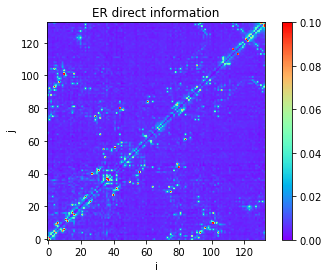

[  1   2   3   4   5   7   8   9  10  11  12  15  16  17  18  19  20  22
  23  24  25  27  28  29  31  32  33  35  36  37  38  39  40  44  46  47
  49  50  51  52  55  57  58  59  61  62  63  64  65  66  67  68  69  70
  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88
  90  91  92  93  94  95  98  99 100 101 102 103 104 105 106 107 108 109
 110 111 112 113 115 116 117 118 119 120 121 122 124 125 126 128 129 130
 131 132 133 134 135 136 137 138 139 140 141 142 143 146 147 148 149 150
 151 152 153 154 155 156 157]
[[(12, 122), 0.30200659951754383], [(49, 50), 0.19325880757017488], [(35, 55), 0.17005967839950345], [(57, 73), 0.16148710116105913], [(136, 139), 0.14630332582707295], [(8, 12), 0.1437366152707125], [(61, 100), 0.14325428643931626], [(39, 58), 0.13704332789211657], [(15, 16), 0.13015225726135685], [(146, 147), 0.12583325723794195], [(37, 93), 0.1250148890194422], [(9, 117), 0.12428382588630146], [(1, 2), 0.11992472502655172], [(5, 113), 0.118016740671679

In [36]:
#print("Direct Information from Expectation reflection:\n",di)
print('ER DI shape: ' , di.shape)
print(removed_cols)
if not removing_cols:
    er_di = np.delete(di, removed_cols,0)
    er_di = np.delete(er_di, removed_cols,1)
else:
    er_di = di

print('Final ER DI shape (cols removed): ', er_di.shape)
if remove_diagonals: 
    ER_di = no_diag(er_di, 4, s_index)
else:
    ER_di = er_di
    
plt.title('ER direct information')
plt.imshow(ER_di,cmap='rainbow',origin='lower')
plt.xlabel('i')
plt.ylabel('j')
plt.clim(0,0.1)
plt.colorbar(fraction=0.045, pad=0.05)
plt.show()


from ecc_tools import scores_matrix2dict
print(s_index)
ER_di_dict = scores_matrix2dict(ER_di, s_index, removed_cols, removing_cols=removing_cols)
print(ER_di_dict[:20])

ct thresh 4.000000 gives auc = 0.937067
ct thresh 4.117647 gives auc = 0.937067
ct thresh 4.235294 gives auc = 0.937596
ct thresh 4.352941 gives auc = 0.938547
ct thresh 4.470588 gives auc = 0.939019
ct thresh 4.588235 gives auc = 0.939859
ct thresh 4.705882 gives auc = 0.941951
ct thresh 4.823529 gives auc = 0.942383
ct thresh 4.941176 gives auc = 0.940197
ct thresh 5.058824 gives auc = 0.940720
ct thresh 5.176471 gives auc = 0.936636
ct thresh 5.294118 gives auc = 0.938965
ct thresh 5.411765 gives auc = 0.936658
ct thresh 5.529412 gives auc = 0.932789
ct thresh 5.647059 gives auc = 0.927995
ct thresh 5.764706 gives auc = 0.924213
ct thresh 5.882353 gives auc = 0.919318
ct thresh 6.000000 gives auc = 0.905372
ER auc max: 4.823529411764706 0.9423830530290256
ct thresh 4.823529 gives auc = 0.942383

Contact threshold:  4.823529411764706


Text(0, 0.5, 'Precision (PPV)')

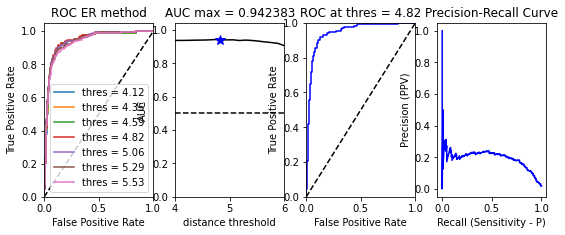

In [38]:
from ecc_tools import roc_curve, roc_curve_new, precision_curve
# find optimal threshold of distance
ct_thres = np.linspace(4.,6.,18,endpoint=True)
n = ct_thres.shape[0]


# Initialize plotting
iplot = [1,3,5,7,9,11,13]
plt.figure(figsize=(9.0,3.2))

# Initalize ROC-curve tile
plt.subplot2grid((1,4),(0,0))
plt.title('ROC various thres')
plt.plot([0,1],[0,1],'k--')

ct_mat = ct


auc_ER = np.zeros(n)
for i in range(n):
    try:
        fpr, tpr, thresholds, auc = roc_curve_new(ct_mat, ER_di, ct_thres[i])
        if i in iplot:
            plt.plot(fpr, tpr, label='thres = %3.2f'%ct_thres[i])
        auc_ER[i] = auc
    except:
        auc_ER[i] = 0
  
# Get ER method's best contact prediction
i0_ER = np.argmax(auc_ER)
print('ER auc max:',ct_thres[i0_ER],auc_ER[i0_ER])
fpr0_ER, tpr0_ER, thresholds_ER, auc = roc_curve_new(ct_mat, ER_di, ct_thres[i0_ER])

# ROC-curve tile settings
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])      
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC ER method")
plt.legend(loc="lower right") 


# Plot ROC, AUC and Precision for best ER contact prediction
# AUC
plt.subplot2grid((1,4),(0,1))
plt.title('AUC max = %f' %(auc_ER[i0_ER]))
plt.plot([ct_thres.min(),ct_thres.max()],[0.5,0.5],'k--')
plt.plot(ct_thres,auc_ER,'k-')
plt.plot(ct_thres[i0_ER],auc_ER[i0_ER], 'b*', markersize=10.)
plt.xlim([ct_thres.min(),ct_thres.max()])
plt.ylim([0,auc_ER.max()+0.1])
plt.xlabel('distance threshold')
plt.ylabel('AUC')
# ROC
plt.subplot2grid((1,4),(0,2))
plt.title('ROC at thres = %3.2f'%(ct_thres[i0_ER]))
plt.plot(fpr0_ER,tpr0_ER,'b-')
plt.plot([0,1],[0,1],'k--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
# Precision-Recall
plt.subplot2grid((1,4),(0,3))
plt.title('Precision-Recall Curve')
precision_ER, recall_ER, threshold = precision_curve(ct_mat, ER_di, ct_thres[i0_ER])
print('\nContact threshold: ', ct_thres[i0_ER])
plt.plot( recall_ER, precision_ER, 'b-', label='thres = %s'%ct_thres[i0_ER])
plt.xlabel('Recall (Sensitivity - P)')
plt.ylabel('Precision (PPV)')

In [43]:
fp_file = "%s%s_%s_ER_fp.npy" % (out_metric_dir, pdb_id, pfam_id)
tp_file = "%s%s_%s_MF_tp.npy" % (out_metric_dir, pdb_id, pfam_id)
np.save(fp_file, fpr0_ER)
np.save(tp_file, tpr0_ER)